_ANN1. Méthode des éléments finis (2025-2026)_

<div class="alert alert-block alert-danger">
<ul>
    <li>Ce TP est à faire en temps limité durant la séance (2h).</li>
    <li>Nous vous demandons de traiter ce sujet <strong>sans aide extérieure</strong> pour assimiler les techniques et algorithmes de base.</li>
    <li>Il faudra envoyer à votre chargé de TD/TP uniquement ce notebook <strong>à la fin de la séance</strong>, de façon à que ce fichier puissent être exécutés sans besoin d'intervention et qu'il renvoient les résultats qui auront été décrits dans dans les cellule de text.</li>
    <li>Vous devez compléter tous les &laquo; <strong>...</strong> &raquo;.</li>
</ul>
</div>

In [1]:
#### Gestion des imports ####
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

# Importation d'utilitaires contenue dans le dossier `src` pour simplifier
# l'utilisation des maillages et de l'affichage.
import src

# Résolution numérique d'un problème de Poisson avec des éléments finis $P^1$

Soit $\Omega$ un ouvert borné à frontière polygonale de $\mathbb{R}^2$ et $f \in L^2(\Omega)$.
On s'intéresse à la résolution numérique du problème de Poisson avec condition aux limites de Neumann :
_Trouver $u\in H^1(\Omega)$ telle que_
$$
    \begin{dcases}
        \begin{array}{rl}
            -\Delta u + u = f, & \text{dans}\ \Omega, \\
            \partial_n u = 0, & \text{sur}\ \partial\Omega.
        \end{array}
    \end{dcases}
    \tag{$\mathcal{N}$}
$$
Nous avons déjà montré pendant le cours que ce problème est bien posé.

### Discrétisation

Soit $\mathcal{T}_h$ une triangulation du domaine $\Omega$, et $V_h$ l'approximation de $H^1(\Omega)$ par des éléments finis $P^1$ associés à la triangulation $\mathcal{T}_h$.
On note $(T_\ell)_{\ell=1,L}$ les triangles de $\mathcal{T}_h$, $(S_I)_{I=1,N}$ les sommets des triangles et $(w_I)_{I=1,N}$ la base de $V_h$ définie par $w_I(S_J) = \delta_{IJ}$, pour $1 \le I,J \le N$.

<span style="color:red">__Question 1.1__</span> - Écrire la formulation variationnelle discrète vérifiée par la solution approchée $u_h$ ?

<span style="color:red">__Question 1.2__</span> - Par construction, la solution approchée s'écrit sous la forme
$$
    u_h(x,y)=\sum_{I=1}^{N} u_h(S_I) w_I(x,y),\qquad \forall (x,y) \in \overline{\Omega}.
$$
Exprimer la formulation variationnelle discrète sous la forme d'un système linéaire équivalent :
\begin{equation*}
    (\mathbb{M}+\mathbb{K}) \vec{U} = \vec{L}, \tag{$\mathcal{D}$}
\end{equation*}
de solution le vecteur $\vec{U} \in \mathbb{R}^N$ dont la $I^{\text{ème}}$ composante vaut $u_h(S_I)$.
Ci-dessus, $\mathbb{M}$ est la matrice de masse et $\mathbb{K}$ est la matrice de rigidité.
Quelles sont les propriétés fondamentales des matrices $\mathbb{M}$ et $\mathbb{K}$ ?

### Maillages

On veut résoudre le problème dans un ouvert $\Omega = ]0, 1[^2$ qui est un carré.
Pour mailler $\Omega$, on choisit le mailleur `Gmsh` (inclus dans les dépendances de ce dossier).
Pour réaliser les calculs, on s'appuie sur la fonction `src.rectangle(low_corner, high_corner, mesh_size)` où `low_corner` et `high_corner` sont des `tuple` de longueur 2 et `mesh_size` est le pas du maillage.

<span style="color:red">__Question 1.3__</span> - Utiliser la fonction `src.rectangle` pour créer un maillage de $\Omega$.

nodes: 12 nodes with 2 coordinates
domains:
  "Gamma": line, 8 elements, 2 nodes per element
  "Omega": triangle, 14 elements, 3 nodes per element


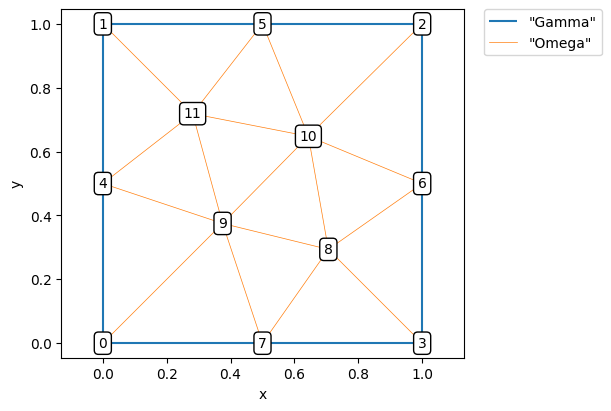

In [2]:
# Réponse 1.3 - début
mesh = src.rectangle((0,0), (1,1), 0.5)
# fin
mesh.print_info()

_, ax = plt.subplots(figsize=(6, 4), layout="constrained")
ax.axis("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
src.plot2d_mesh(ax, mesh, show_nodes_indices=True)
plt.show()

La fonction `src.rectangle` renvoie un objet de la classe `src.Mesh`. Cette classe contient deux attributs `nodes` et `domains`.

In [3]:
print(mesh.nb_nodes)

12


In [4]:
print(mesh.nodes)

[[0.         0.        ]
 [0.         1.        ]
 [1.         1.        ]
 [1.         0.        ]
 [0.         0.5       ]
 [0.5        1.        ]
 [1.         0.5       ]
 [0.5        0.        ]
 [0.70625    0.29375   ]
 [0.375      0.375     ]
 [0.64375    0.64791667]
 [0.28125    0.71875   ]]


In [5]:
print(mesh.domains["Omega"]["triangle"])

[[ 5  2 10]
 [ 7  0  9]
 [ 0  4  9]
 [ 2  6 10]
 [ 4  1 11]
 [ 1  5 11]
 [ 6  3  8]
 [ 3  7  8]
 [ 5 10 11]
 [ 8  7  9]
 [ 8  9 10]
 [ 9  4 11]
 [10  9 11]
 [ 6  8 10]]


In [6]:
print(mesh.nb_elements("Omega", "triangle"))

14


In [7]:
print(mesh.domains["Gamma"]["line"])

[[0 4]
 [4 1]
 [1 5]
 [5 2]
 [2 6]
 [6 3]
 [3 7]
 [7 0]]


In [8]:
print(mesh.nb_elements("Gamma", "line"))

8


In [9]:
print(mesh.domain_node_indices("Gamma", "line"))

[7 3 6 2 5 1 4 0]


<span style="color:red">__Question 1.4__</span> - Pouvez-vous expliquer avec des mots quelle est la signification des objets suivants ?
- `mesh.nb_nodes`
- `mesh.nodes`
- `"Omega"`
- `mesh.domains["Omega"]["triangle"]`
- `mesh.nb_elements("Omega", "triangle")`
- `"Gamma"`
- `mesh.domains["Gamma"]["line"]`
- `mesh.nb_elements("Gamma", "line")`
- `mesh.domain_node_indices("Gamma", "line")`

__À noter__ que les noms des structures de données du maillage définies dans les TPs Python sont différentes de celles introduites dans le cours magistral à savoir `Nbpt`, `Nbtri`, `Coorneu`, `Refneu`, `Numtri`, `Nbaretes`, `Numaretes`.
Cependant, leurs significations restent les mêmes.

<span style="color:green">__Réponse 1.4__</span> - 

nb_nodes est le nombre de noeuds, 

nodes liste les coordonnées des noeuds,

"Omega" c'est le domaine ouvert, 

domains["Omega"]["triangle"] liste les triangles de "Omega" en donnant pour chacun les trois noeuds constituant leurs sommets,

nb_elements("Omega", "triangle") est le nombre de triangles de "Omega", 

"Gamma" est le bord de "Omega", 

domains["Gamma"]["line"] liste les arêtes sur le bord en donnant les deux noeuds qu'elles relient, 

nb_elements("Gamma", "line") est le nombre d'arêtes sur le bord, 

domain_node_indices("Gamma", "line") liste les noeuds sur le bords.

Les données `"Gamma"` et `mesh.domains["Gamma"]["line"]` ne seront pas utilisés dans ce TP.

### Calcul des Matrices élémentaires

Pour calculer les matrices élémentaires sur un triangle, on peut utiliser les formules ci-dessous.
Soit $T_\ell$ un triangle de sommets $S_1(x_1,y_1)$, $S_2(x_2,y_2)$, et $S_3(x_3,y_3)$.
Les fonctions de base locales sont égales aux coordonnées barycentriques $\lambda_1$, $\lambda_2$ et $\lambda_3$.
En un point $(x,y)$ du triangle, celles-ci sont données par les formules suivantes :
\begin{align*}
    \lambda_1(x,y) & = \frac{1}{D} (y_{2,3} (x-x_3) - x_{2,3} (y-y_3))\\
    \lambda_2(x,y) & = \frac{1}{D} (y_{3,1} (x-x_1) - x_{3,1} (y-y_1))\\
    \lambda_3(x,y) & = \frac{1}{D} (y_{1,2} (x-x_2) - x_{1,2} (y-y_2))
\end{align*}
où $x_{i,j} = x_i-x_j$, $y_{i,j} = y_i-y_j$ pour $i$ et $j$ différents dans $\{1,2,3\}$, et $D = x_{23}y_{31}-x_{31}y_{23}$.
Notons que $D$ est égal, au signe près, à deux fois la surface du triangle.
Pour $(k_1,k_2,k_3) \in \mathbb{N}^3$, on a le résultat suivant :
\begin{equation}
    \int_{T_\ell} \lambda_1^{k_1} \, \lambda_2^{k_2} \, \lambda_3^{k_3} \, \mathrm{d}\Omega = 2\frac{{k_1}!\,{k_2}!\,{k_3}!}{(k_1+k_2+k_3+2)!}\,{\rm aire}(T_\ell).
\end{equation}

<span style="color:red">__Question 1.5__</span> - Soit $T_\ell$ un triangle de sommets $S_1(x_1,y_1)$, $S_2(x_2,y_2)$ et $S_3(x_3,y_3)$.
Compléter les fonctions `elem_mat_K` et `elem_mat_M` qui a partir des coordonnées des trois sommets d'un triangle donnent respectivement les matrices élémentaires de rigidité et de masse.

_Il est conseillé de vérifier le calcul des matrices élémentaires en le comparant à un calcul fait à la main pour le triangle de référence (composé des sommets $(0,0)$, $(1,0)$ et $(0,1)$)._

In [10]:
def elem_mat_K(S1, S2, S3, tol=1e-8):
    """Calcule la matrices de raideur elementaire en P1 lagrange.

    NOTE (1) le calcul est exact (pas de condensation de masse)
         (2) calcul direct a partir des formules donnees par les coordonnees barycentriques

    Parameters
    ----------
    S1, S2, S3 : les 2 coordonnees des 3 sommets du triangle (vecteurs reels 1x2)

    Returns
    -------
    matrice de raideur elementaire (matrice 3x3)
    """

    # preliminaires, pour faciliter la lecture:
    x1 = S1[0]
    y1 = S1[1]
    x2 = S2[0]
    y2 = S2[1]
    x3 = S3[0]
    y3 = S3[1]

    # D est, au signe pres, deux fois l'aire du triangle
    D = (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)

    if abs(D) <= tol:
        raise ValueError("l'aire d'un triangle est nulle !!!")

    # les 3 normales à l'arête opposées (de la longueur de l'arête)
    normal = np.array(
        [
            [y2 - y3, x3 - x2],
            [y3 - y1, x1 - x3],
            [y1 - y2, x2 - x1],
        ],
        dtype=np.float64,
    )

    # calcul de la matrice de raideur
    # Réponse 1.6 - début
    K_elem = (abs(D)/(2*D*D))*normal@normal.T
    # fin

    return K_elem

#%%%%%%%%%%% CORRECTION %%%%%%
# Test rigidite elementaire ?
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [11]:
def elem_mat_M(S1, S2, S3, tol=1e-8):
    """calcule la matrices de masse elementaire en P1 lagrange.

    NOTE (1) le calcul est exact (pas de condensation de masse)
         (2) calcul direct à partir des formules donnees par les coordonnees barycentriques

    Parameters
    ----------
    S1, S2, S3 : les 2 coordonnees des 3 sommets du triangle (vecteurs reels 1x2)

    Returns
    -------
    matrice de masse elementaire (matrice 3x3)
    """

    # preliminaires, pour faciliter la lecture:
    x1 = S1[0]
    y1 = S1[1]
    x2 = S2[0]
    y2 = S2[1]
    x3 = S3[0]
    y3 = S3[1]

    # D est, au signe pres, deux fois l'aire du triangle
    D = (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)

    if abs(D) <= tol:
        raise ValueError("l'aire d'un triangle est nulle !!!")

    # calcul de la matrice de raideur
    # Réponse 1.6 - début
    M_elem = ((abs(D)/2.0)/12.0)*np.array([[2,1,1], [1,2,1], [1,1,2]])
    # fin

    return M_elem
   
#%%%%%%%%%%% CORRECTION %%%%%%
# Test masse elementaire ?
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

### Assemblage des matrices

On rappelle l'algorithme d'assemblage :

&emsp;$\mathbb{M} = 0$, $\mathbb{K} = 0$<br/>
&emsp;Pour $\ell = 1, \ldots, L$<br/>
&emsp;&emsp;Détermination des coordonnées des sommets du triangle $\ell$<br/>
&emsp;&emsp;Calcul des contributions élémentaires $\mathbb{M}^{\ell}$ and $\mathbb{K}^{\ell}$<br/>
&emsp;&emsp;Pour $i=1,2,3$<br/>
&emsp;&emsp;&emsp;$I=\text{local} \to \text{global}(\ell ,i)$<br/>
&emsp;&emsp;&emsp;Pour $j=1,2,3$<br/>
&emsp;&emsp;&emsp;&emsp;$J=\text{local} \to \text{global}(\ell ,j)$<br/>
&emsp;&emsp;&emsp;&emsp;$\mathbb{M}_{IJ}=\mathbb{M}_{IJ}+\mathbb{M}^{\ell}_{ij}$ et $\mathbb{K}_{IJ}=\mathbb{K}_{IJ}+\mathbb{K}^{\ell}_{ij}$<br/>
&emsp;&emsp;&emsp;Fin pour $j$<br/>
&emsp;&emsp;Fin pour $i$<br/>
&emsp;Fin pour $\ell$

<span style="color:red">__Question 1.6__</span> - Compléter la partie assemblage des matrices $\mathbb{M}$ et $\mathbb{K}$.

In [12]:
def mat_KM(mesh):
    """Calcule les matrices de raideur et de masse en P1 lagrange.

    Parameters
    ----------
    mesh : Mesh
        le maillage

    Returns
    -------
    K la matrice de raideur (matrice sparse de taille nb_nodes x nb_nodes)
    M la matrice de masse (matrice sparse de taille nb_nodes x nb_nodes)
    """
    K = sp.dok_array((mesh.nb_nodes, mesh.nb_nodes), dtype=np.float64)
    M = sp.dok_array((mesh.nb_nodes, mesh.nb_nodes), dtype=np.float64)

    triangles = mesh.domains["Omega"]["triangle"]
    for k in range(mesh.nb_elements("Omega", "triangle")):
        # Coordonnées des sommets du triangles
        # Réponse 1.7 - début
        S1, S2, S3 = mesh.nodes[triangles[k][0]], mesh.nodes[triangles[k][1]], mesh.nodes[triangles[k][2]]

        # calcul des matrices elementaires du triangle
        K_elem = elem_mat_K(S1, S2, S3)
        M_elem = elem_mat_M(S1, S2, S3)

        # On fait l'assemblage de la matrice globale et du second membre
        #%%%%%%%%%%%%%% CORRECTION %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # C'est tres complique! Utilisez une double boucle pour i,j = 0,1,2
        # Je ne sais pas où mais vous avez commis une erreur
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        K[triangles[k][0], triangles[k][0]] = K_elem[0][0]
        K[triangles[k][0], triangles[k][1]] = K_elem[0][1]
        K[triangles[k][0], triangles[k][2]] = K_elem[0][2]
        K[triangles[k][1], triangles[k][0]] = K_elem[1][0]
        K[triangles[k][1], triangles[k][1]] = K_elem[1][1]
        K[triangles[k][1], triangles[k][2]] = K_elem[1][2]
        K[triangles[k][2], triangles[k][0]] = K_elem[2][0]
        K[triangles[k][2], triangles[k][1]] = K_elem[2][1]
        K[triangles[k][2], triangles[k][2]] = K_elem[2][2]

        M[triangles[k][0], triangles[k][0]] = M_elem[0][0]
        M[triangles[k][0], triangles[k][1]] = M_elem[0][1]
        M[triangles[k][0], triangles[k][2]] = M_elem[0][2]
        M[triangles[k][1], triangles[k][0]] = M_elem[1][0]
        M[triangles[k][1], triangles[k][1]] = M_elem[1][1]
        M[triangles[k][1], triangles[k][2]] = M_elem[1][2]
        M[triangles[k][2], triangles[k][0]] = M_elem[2][0]
        M[triangles[k][2], triangles[k][1]] = M_elem[2][1]
        M[triangles[k][2], triangles[k][2]] = M_elem[2][2]
        # fin

    return (K.tocsc(), M.tocsc())

M =  [[0.015625   0.         0.         0.         0.0078125  0.
  0.         0.0078125  0.         0.0078125  0.         0.        ]
 [0.         0.01171875 0.         0.         0.00585938 0.00585937
  0.         0.         0.         0.         0.         0.00585937]
 [0.         0.         0.01484375 0.         0.         0.00733507
  0.00742187 0.         0.         0.         0.00742187 0.        ]
 [0.         0.         0.         0.01223958 0.         0.
  0.00611979 0.00611979 0.00611979 0.         0.         0.        ]
 [0.0078125  0.00585938 0.         0.         0.00976563 0.
  0.         0.         0.         0.00488281 0.         0.00488281]
 [0.         0.00585937 0.00733507 0.         0.         0.00978733
  0.         0.         0.         0.         0.00489366 0.00489366]
 [0.         0.         0.00742187 0.00611979 0.         0.
  0.00974392 0.         0.00487196 0.         0.00487196 0.        ]
 [0.0078125  0.         0.         0.00611979 0.         0.
  0.    

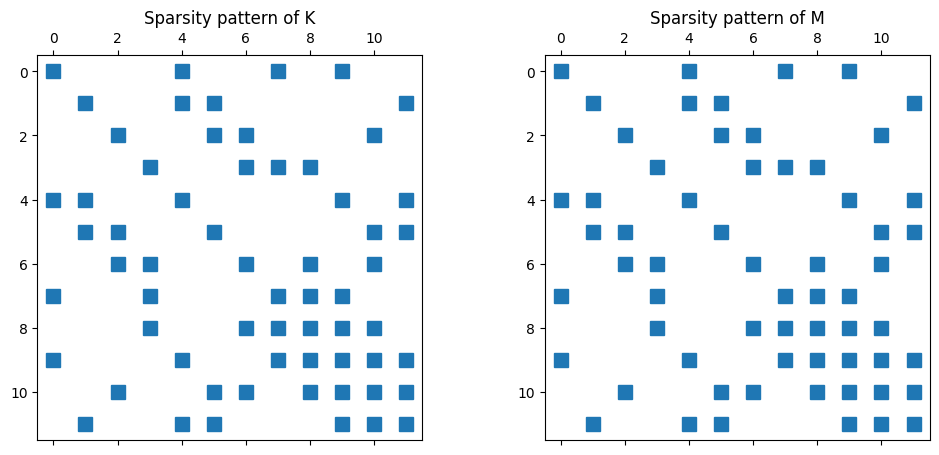

In [14]:
# Calcul des matrices EF
K, M = mat_KM(mesh)

#%%%%%%%%%%%% CORRECTION %%%%%%%%%%%%%%
#
print("M = ",M.toarray())
print("\nK = ",K.toarray())
#
# Vos matrices de masse et de rigidite 
# sont fausses
#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

axs[0].set_title("Sparsity pattern of K")
axs[0].spy(K, markersize=10)

axs[1].set_title("Sparsity pattern of M")
axs[1].spy(M, markersize=10)

plt.show()

### Calcul du second membre

<span style="color:red">__Question 1.7__</span> - On suppose dans un premier temps que $f=1$.
En remarquant que $1 \in V_h$, calculer le vecteur second membre $\vec{L}$ à partir de la matrice de masse $\mathbb{M}$ et d'un vecteur calculé dans la fonction `f`.

In [108]:
def vec_L(fct, mass_matrix, nodes):
    """Calcule le second membre L.

    Parameters
    ----------
    fct : la fonction `fct` prend comme argument les noeuds du maillage (tableau de taille `(nb_nodes, 2)`)
          et renvoie un vecteur de taille `nb_nodes` qui contient les valeurs de `fct` en chaque noeud. Un
          exemple de fonction `fct` est donné ci-dessous :
      ```def f(nodes):
            x, y = nodes[:, 0], nodes[:, 1]
            return np.cos(x) * np.exp(y)
      ```

    mass_matrix : matrice de masse (matrice sparse de taille nb_nodes x nb_nodes)

    nodes : les coordonnées des noeuds du maillage (matrice de taille nb_nodes x 2)

    Returns
    -------
    vecteur L (vecteur de taille nb_nodes x 1)
    """

    # Réponse 1.8 - début
    return mass_matrix@fct
    # fin

In [109]:
def fct_one(nodes):
    return np.ones(nodes.shape[0], dtype=np.float64)


# Réponse 1.8 - début
L = vec_L(mesh.nodes, M, mesh.nodes)
# fin

with np.printoptions(precision=3):
    print(f"fct_one(nodes) = {fct_one(mesh.nodes)}")
    print(f"L = {L}")

fct_one(nodes) = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
L = [[0.007 0.007]
 [0.005 0.025]
 [0.031 0.031]
 [0.026 0.005]
 [0.003 0.016]
 [0.017 0.03 ]
 [0.03  0.017]
 [0.016 0.003]
 [0.025 0.01 ]
 [0.014 0.014]
 [0.028 0.028]
 [0.01  0.025]]


<span style="color:red">__Question 1.8__</span> - Rappeler l'expression du second membre $\vec{L}$ pour une donnée générale $f\in \mathcal{C}^{0}(\overline\Omega)$.
En approchant la donnée $f$ par son interpolation $\pi_h f$ dans la base $\left( w_{I} \right)_{I=1,N}$, donner une approximation du second membre $\vec{L}$ faisant intervenir la matrice de masse.

On admettra que quand on remplace $f$ par son interpolée $\pi_h f$ de $V_h$, l'approximation par des éléments finis $P^1$ du problème n'est pas altérée.

## Validation

On veut vérifier que le code calcule une solution approchée $u_h$ correcte.
Pour cela, on résout le problème $(\mathcal{N})$ avec une solution $u$ connue égale à $u(x,y)=\cos(2\pi x)\,\cos(3\pi y)$, pour $(x,y) \in \overline{\Omega}$.

<span style="color:red">__Question 1.9__</span> - Calculer la donnée $f$ correspondante et modifier la fonction `f`.

In [110]:
def f(nodes):
    x, y = nodes[:, 0], nodes[:, 1]
    # Réponse 1.10 - début
    return np.cos(2*np.pi*x)*np.cos(3*np.pi*y)
    # fin


# Réponse 1.8 - début
L = vec_L(f(mesh.nodes), M, mesh.nodes)
# fin

# J'ajoute ici l'affichage de L
with np.printoptions(precision=3):
    print(f"L = {L}")

L = [ 0.013 -0.007 -0.012  0.008  0.004 -0.007 -0.003  0.009  0.004  0.007
 -0.005 -0.002]


<span style="color:red">__Question 1.10__</span> - Utiliser la fonction `spsolve` to solve $(\mathcal{D})$.

In [111]:
# calcul de la solution
# Réponse 1.11 - début
U = sp.linalg.spsolve(M+K, L)
# fin

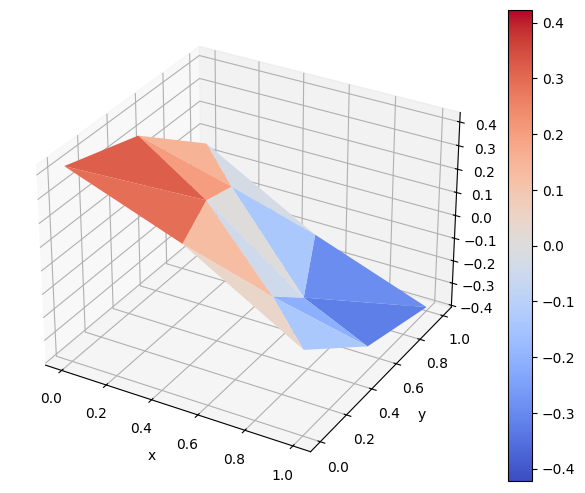

In [112]:
# Affichage de la solution
fig, ax = plt.subplots(layout="constrained", subplot_kw={"projection": "3d"})
ax.axis("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")

U_max = np.abs(U).max()
src.plot3d_fct_trimesh(
    ax, U, mesh, trisurf_kwargs={"cmap": "coolwarm", "vmin": -U_max, "vmax": U_max}
)
plt.show()

<span style="color:red">__Question 1.11__</span> - En assimilant $u$ à son interpolée $\pi_h u$, donner une estimation de la norme $L^2$ de l'erreur, $\lVert u-u_h \rVert_{L^2(\Omega)}$, faisant intervenir la matrice de masse $\mathbb{M}$.
Comment évolue cette erreur en fonction de $h$ dans le cas de la première géométrie ?

<span style="color:red">__Question 1.12__</span> - En assimilant $u$ à son interpolée $\pi_hu$, donner une estimation de la semi-norme $H^1$ de l'erreur, $\lvert u-u_h \rvert_1 = \lVert \nabla u-\nabla u_h \rVert_{L^2(\Omega)^2}$, faisant intervenir la matrice de rigidité $\mathbb{K}$.
Comment évolue cette erreur en fonction de $h$ dans le cas de la première géométrie ?

<div class="alert alert-block alert-info">
<strong>Comment effectuer une étude complète de l'erreur</strong>

Tracer un graphe __en échelle log-log__ de l'erreur normalisé en norme $L^2$, puis en semi-norme $H^1$, en fonction du réciproque du pas du maillage $h$.
Plus précisément :
- En abscisse, on a $\log(1/h)$ et en ordonnée, on a $\log(\lVert u-u_h \rVert_{L^2(\Omega)}) / \lVert u\rVert_{L^2(\Omega)})$, puis $\log(\lvert u-u_h \rvert_{H^1(\Omega)}) / \lvert u\rvert_{H^1(\Omega)})$.
- Choisir au moins $3$ ou $4$ valeurs différentes de $h$ : $h_1 > h_2 > h_3 > h_4$ (souvent, on choisit $h_{i+1} = \alpha h_i$ pour que les points du graphe soient bien espacés en échelle $\log$).
- Effectuer une régression linéaire (par exemple par la fonction ` np.polyfit`) pour calculer les coefficients de la droite de régression.
- Tracer les courbes d'erreur (mettre bien en évidence les points sur les courbes), ainsi que les droites de régression (avec un autre style, par exemple en pointillé).

</div>

<span style="color:red">__Question 1.13__</span> - Étant donné la liste `list_h` de pas de maillage $h$, tracez les fonctions
\begin{align*}
    \log (1/h) & \mapsto \log \left( \lVert u-u_h \rVert_{L^2(\Omega)} / \lVert u \rVert_{L^2(\Omega)} \right), \\
    \log (1/h) & \mapsto \log \left( \lvert u-u_h \rvert_1 / \lvert u \rvert_1 \right).
\end{align*}

In [113]:
def u_excat(nodes):
    x, y = nodes[:, 0], nodes[:, 1]
    return np.cos((2 * np.pi) * x) * np.cos((3 * np.pi) * y)


def erreurs():
    nb_meshes = 4
    list_h = np.geomspace(0.1, 0.01, num=nb_meshes)
    print(f"h₁, h₂, ... = {list_h}")

    # Calcul des erreurs relatives L2 et H1
    # Réponse 1.14 - début
    # ...
    err_L2 = ...
    err_H1 = ...

    # fin

    return (list_h, err_L2, err_H1)

In [114]:
def graphes_erreurs():
    """Graphes des erreurs relatives L2 et H1"""

    mesh_sizes, err_L2, err_H1 = erreurs()

    # Réponse 1.14 - début
    ...
    # fin


graphes_erreurs()

h₁, h₂, ... = [0.1        0.04641589 0.02154435 0.01      ]


### Résolution d'un problème similaire

Utiliser votre code pour résoudre le problème suivant : _Trouver $u \in H^1(\Omega)$ telle que_
\begin{equation*}
    \begin{dcases}
        \begin{array}{rl}
            -\Delta u = f, & \text{dans}\ \Omega, \\
            \partial_n u = 0, & \text{sur}\ \partial\Omega.
        \end{array}
    \end{dcases}
    \tag{$\mathcal{N}'$}
\end{equation*}

<span style="color:red">__Question bonus__</span> - Que se passe-t-il ? Expliquer.

<span style="color:green">__Réponse bonus__</span> - ...